In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/README.md
/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet
/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet


# Importing Libraries

In [2]:
import os
import io
import glob
import math
from PIL import Image
import cv2
from numpy.random import randint
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

2024-06-06 22:25:30.853577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 22:25:30.853704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 22:25:30.984397: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Training DataFrame Creation

In [3]:
df= pd.read_parquet('/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet')
df.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


In [4]:
def load_image_as_np_array(image_bytes):
    try:
        np_array = np.frombuffer(image_bytes, np.uint8)
        image = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            return image
        else:
            print("Error: Unable to decode image.")
            return None
    except Exception as e:
        print(f"Error loading image: {e}")
        return None


In [5]:
x = []
y = []
for i in range(len(df)):
    row = df.iloc[i]
    image_info = row['image']
    image_bytes = image_info['bytes']
    image_path = image_info['path']
    image_label = row['label']
    image_np_array = load_image_as_np_array(image_bytes)
    if image_np_array is not None:
        if len(image_np_array.shape) == 3:
            x.append(image_np_array)
            y.append(image_label)
        else:
            print(f"Ignoring image with unexpected shape: {image_np_array.shape}")

In [6]:
x[0].shape

(128, 128, 3)

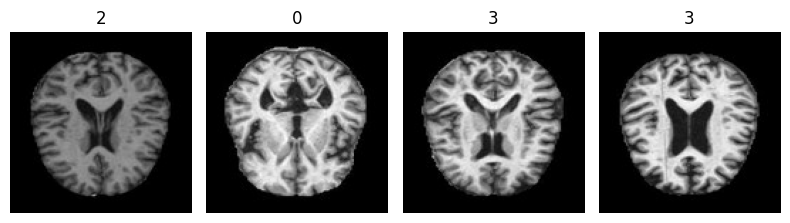

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(8, 3))

for i in range(4): 
    ax = axes[i]
    ax.imshow(x[i], cmap='viridis')
    ax.set_title(y[i])
    ax.axis('off')

plt.tight_layout()
plt.show()


# Train_Test Split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.10,random_state=51,shuffle=True)

In [9]:
x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

# Data Normalisation

In [10]:
x_train=x_train/255.0
x_test=x_test/255.0

# Model Building

In [11]:
model=keras.models.Sequential([
    keras.layers.Conv2D(32,kernel_size=(3,3), input_shape=(128,128,3),activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(0.05),
    keras.layers.Conv2D(64,(3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128,(3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(256,(3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(512,(3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(0.05),
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dropout(0.01),
    keras.layers.Dense(4,activation='softmax'),
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,25

 Total params: 1,843,844 (7.03 MB)

 Trainable params: 1,841,604 (7.03 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [13]:
class new_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.9855:
            self.model.stop_training = True
            
stop_epoch= new_callback()

In [14]:
warnings.filterwarnings('ignore')
model_hist=model.fit(x_train,y_train,epochs=50, batch_size=32, callbacks=[stop_epoch], validation_split=.05)

Epoch 1/50
  5/137 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.4315 - loss: 1.5535

I0000 00:00:1717712763.730094      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717712763.753686      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5297 - loss: 1.0846

W0000 00:00:1717712784.005721      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717712784.941938      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


137/137 ━━━━━━━━━━━━━━━━━━━━ 39s 167ms/step - accuracy: 0.5300 - loss: 1.0837 - val_accuracy: 0.4805 - val_loss: 1.3051
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6582 - loss: 0.7705 - val_accuracy: 0.5281 - val_loss: 1.8805
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7453 - loss: 0.6198 - val_accuracy: 0.5844 - val_loss: 1.2934
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8058 - loss: 0.4845 - val_accuracy: 0.6710 - val_loss: 0.9772
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8666 - loss: 0.3418 - val_accuracy: 0.7316 - val_loss: 0.7447
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9217 - loss: 0.2202 - val_accuracy: 0.6623 - val_loss: 0.8865
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9335 - loss: 0.1780 - val_accuracy: 0.7316 - val_loss: 0.8212
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9588 - loss: 0.1240 - val_accuracy: 0.9

# Model Evaluation

In [15]:
los, accrcy = model.evaluate(x_test,y_test, verbose=0)
print(f'Accuracy: {accrcy*100}%')

Accuracy: 94.3359375%


In [16]:
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
y_pred[:10]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


W0000 00:00:1717712829.265021      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([0, 1, 2, 2, 2, 3, 2, 2, 2, 2])

In [17]:
mapping_dict={
    0: 'Mild_Demented',
    1: 'Moderate_Demented',
    2: 'Non_Demented',
    3: 'Very_Mild_Demented'
}
class_names= list(mapping_dict.values())
print(classification_report(y_test,y_pred, target_names=class_names))

                    precision    recall  f1-score   support

     Mild_Demented       0.92      0.96      0.94        70
 Moderate_Demented       1.00      1.00      1.00         2
      Non_Demented       0.94      0.97      0.95       265
Very_Mild_Demented       0.96      0.90      0.93       175

          accuracy                           0.94       512
         macro avg       0.95      0.96      0.95       512
      weighted avg       0.94      0.94      0.94       512



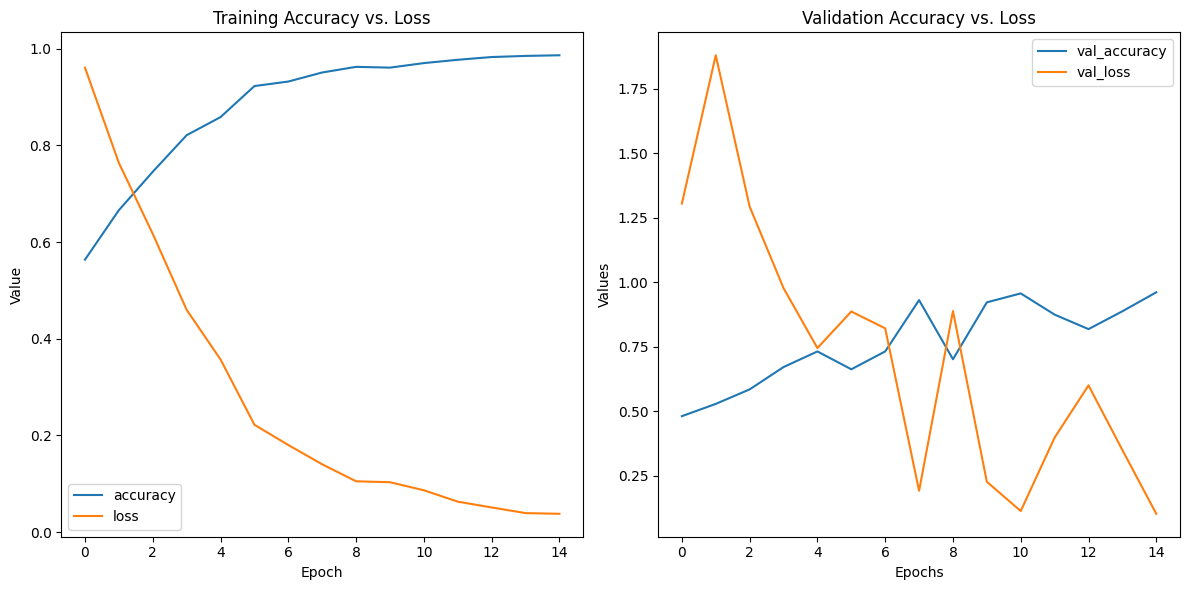

In [18]:
#pd.DataFrame(model_hist.history).plot()
history_df = pd.DataFrame(model_hist.history)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
history_df[['accuracy', 'loss']].plot(ax=ax1)
ax1.set_title('Training Accuracy vs. Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Value')
history_df[['val_accuracy', 'val_loss']].plot(ax=ax2)
ax2.set_title('Validation Accuracy vs. Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Values')
plt.tight_layout()
plt.show()


# Validation using Unseen Test DataSet

In [19]:
test_df=pd.read_parquet('/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet')
test_df.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [20]:
test_x=[]
test_y=[]
for i in range(len(test_df)):
    row = test_df.iloc[i]
    image_info = row['image']
    image_bytes = image_info['bytes']
    image_path = image_info['path']
    image_label=row['label']
    image_np_array = load_image_as_np_array(image_bytes)
    if image_np_array is not None:
        if len(image_np_array.shape) == 3:
            test_x.append(image_np_array)
            test_y.append(image_label)
        else:
            print(f"Ignoring image with unexpected shape: {image_np_array.shape}")

In [21]:
test_x=np.array(test_x)
test_x=test_x/255.0
test_y=np.array(test_y)

In [22]:
l, a = model.evaluate(test_x, test_y, verbose=0)
print(f'Accuracy: {a*100}%')

Accuracy: 93.359375%


In [23]:
test_y_pred=model.predict(test_x)
test_y_pred=np.argmax(test_y_pred, axis=1)
test_y_pred[:5]

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([2, 0, 2, 3, 0])

In [24]:
print(classification_report(test_y,test_y_pred,target_names=class_names))

                    precision    recall  f1-score   support

     Mild_Demented       0.95      0.95      0.95       172
 Moderate_Demented       1.00      0.93      0.97        15
      Non_Demented       0.92      0.97      0.94       634
Very_Mild_Demented       0.95      0.88      0.91       459

          accuracy                           0.93      1280
         macro avg       0.95      0.93      0.94      1280
      weighted avg       0.93      0.93      0.93      1280



## Replacing Values with Alzheimer's Disease Names

In [25]:
test_y = np.vectorize(mapping_dict.get)(test_y)
test_y_pred = np.vectorize(mapping_dict.get)(test_y_pred)


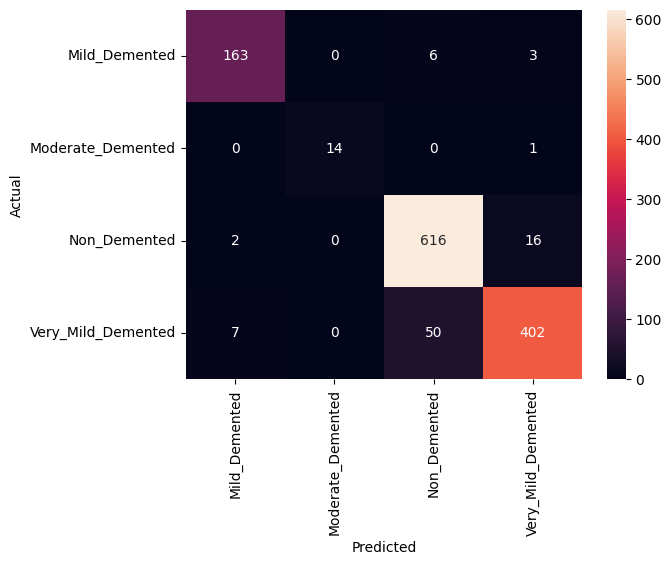

In [26]:
cm=confusion_matrix(test_y,test_y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Visualisations of Predictions

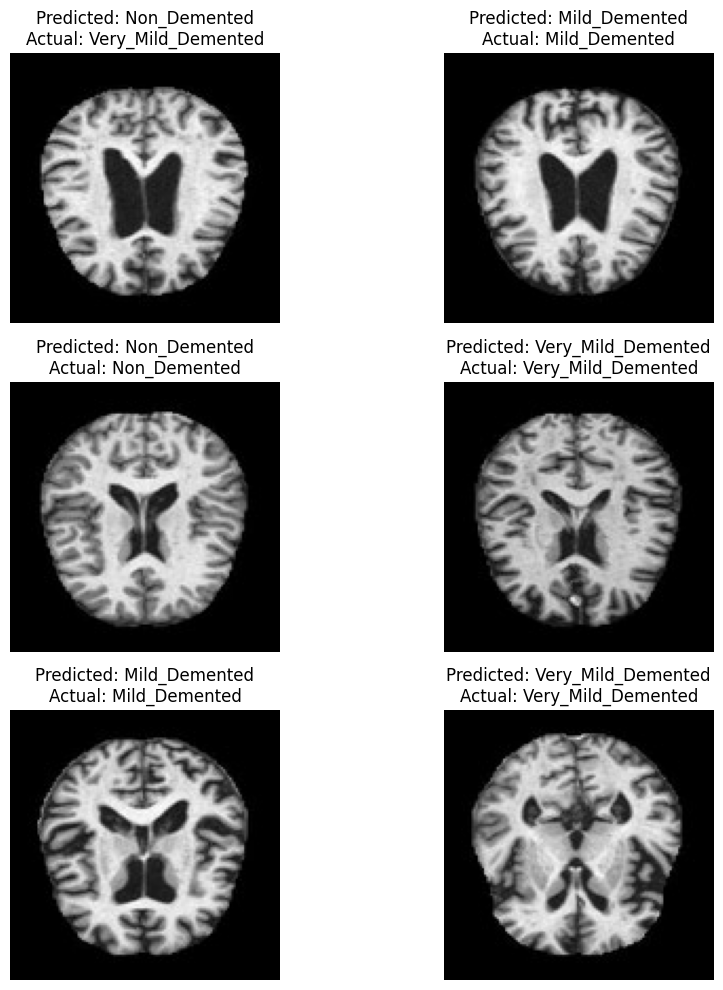

In [27]:
%matplotlib inline

num_images = randint(6, 12)
rows = math.ceil(math.sqrt(num_images))
cols = math.ceil(num_images / rows)

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(num_images):
    row = i // cols
    col = i % cols
    ax = axes[row, col] if num_images > 1 else axes
    ax.imshow(test_x[i], cmap='viridis')
    ax.set_title(f"Predicted: {test_y_pred[i]}\nActual: {test_y[i]}")
    ax.axis('off')

# Hide any unused subplots
for i in range(num_images, rows * cols):
    if num_images > 1:
        fig.delaxes(axes.flatten()[i])
    else:
        fig.delaxes(axes)

plt.tight_layout()
plt.show()


**Thank you. Please upvote if you like this Notebook.**